# GSTORE CUSTOMER REVENUE PREDICTION - COMPLETE EDA
***BY HARISH JULAPALLI***

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

 [](http://)[](http://) In this notebook, I've analysed GSTORE customers extensively based on various attributes. I have built visualzations to tell which specific customers made contribute to revenue of the GSTORE.

> Loading all the required libraries:

In [149]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import json

import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%matplotlib inline
plt.style.use('ggplot')

import os
print(os.listdir("../input"))

['train_v2.csv', 'test_v2.csv', 'sample_submission_v2.csv']


Loading the dataset:

In [150]:
df = pd.read_csv("../input/train_v2.csv", nrows = 10000)
df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


As seen from a small sample of the dataset, it is evident that many columns have JSON values in them, whcih inturn have many attributes. So, we have to find a way to extract these features as well.

This function load_df helps to extract features from these JSON columns:

In [151]:
def load_df(csv_path='../input/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df
        

Now loading train and test sets:

In [152]:
train = load_df(nrows = 200000)
train.head()

Loaded train_v2.csv. Shape: (200000, 60)


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo 

In [153]:
test = load_df(csv_path='../input/test_v2.csv', nrows = 50000)
test.head()

Loaded test_v2.csv. Shape: (50000, 59)


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,India,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Delhi,Southern Asia,NaN,4,NaN,3,1,973,NaN,NaN,NaN,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,San Francisco,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,4,NaN,3,1,49,NaN,NaN,NaN,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,1526067157,2,1526067157,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,not available in demo dataset,Northern Ame

In [154]:
train.drop(['customDimensions','hits'], axis = 1, inplace = True)
#train.head()

In [155]:
test.drop(['customDimensions','hits'], axis = 1, inplace = True)

Remove columns which has only single category in them, as they does not add any value:

In [156]:
single_cat_cols = [col for col in train.columns if train.nunique()[col] == 1]

In [157]:
train.drop(single_cat_cols, axis =1, inplace = True)

In [158]:
single_cat_cols_test = [col for col in test.columns if test.nunique()[col] == 1]
test.drop(single_cat_cols_test , axis =1, inplace = True)

In [159]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,2,2,2,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,2,2,1,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,2,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,2,2,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google


## Exploratory Analysis

Number of customers who visited GSTORE:

In [160]:
print(f"Number of unique customers: {train.fullVisitorId.nunique()}")

Number of unique customers: 177052


Number of customers who visited GSTORE more than once:

In [161]:
print(f"Number of customers who visited the site more than once: {train.shape[0]-train.fullVisitorId.nunique()}")

Number of customers who visited the site more than once: 22948


Doing some conversions and filling missing values of transaction revenue with 0's:

In [162]:
train['totals_transactionRevenue'] = train['totals_transactionRevenue'].astype('float')

In [163]:
train['totals_transactionRevenue'].fillna(0, inplace = True)

In [164]:
train['totals_transactionRevenue'].sum()

264558410000.0

Isolating customers who made purchases on Gstore form the whole set:

In [165]:
reven_group = train.groupby('fullVisitorId')['totals_transactionRevenue'].sum().reset_index()

**Plotting customers who spent money with indices on horizontal axis and log revenue on vertical axis:[[](http://)](http://)**

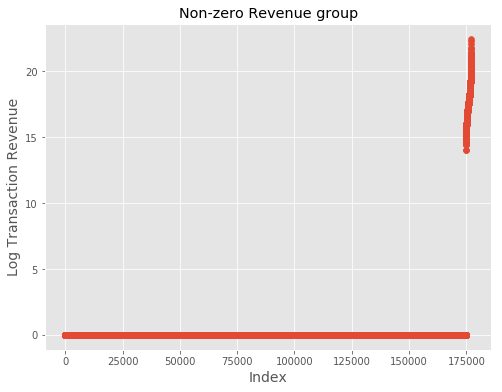

In [166]:
plt.figure(figsize = (8,6))
plt.scatter(range(reven_group.shape[0]), np.sort(np.log1p(reven_group['totals_transactionRevenue'])))
plt.xlabel('Index', fontsize = 14)
plt.ylabel('Log Transaction Revenue', fontsize = 14)
plt.title("Non-zero Revenue group")
plt.show()

It can be observed that even in non-zero revenue group there are only a few customers who made large transactions. But the above plot is little obscure.

A Pie chart can show this variation very clearly.

In [167]:
print(f"Percentage of Revenue generating customers: {(train[train['totals_transactionRevenue'] > 0].shape[0]/train.shape[0])*100}")

Percentage of Revenue generating customers: 1.0835


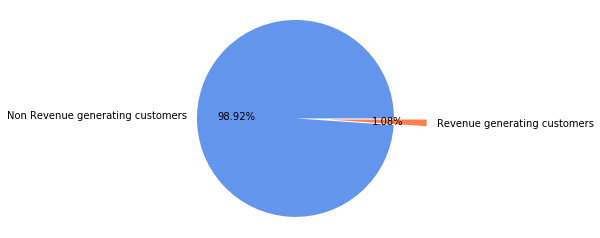

<Figure size 720x720 with 0 Axes>

In [168]:
#Pie-chart

labels = ['Non Revenue generating customers', 'Revenue generating customers']
non_revenue_perc = (train[train['totals_transactionRevenue'] == 0].shape[0]/train.shape[0])*100
revenue_perc = (train[train['totals_transactionRevenue'] > 0].shape[0]/train.shape[0])*100
sizes = [non_revenue_perc, revenue_perc]
explode = (0, 1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels = labels, autopct='%0.2f%%', colors = ['cornflowerblue','coral'], radius = 3)
plt.figure(figsize=(10,10))
ax1.axis('equal')
plt.tight_layout()
plt.show()

Only **1.08%** of total customers of Gstore actually made purchases.

**Distribution of target variable: totals_transactionRevenue**

In [169]:
#Distribution of revenue generated
rg = train[train['totals_transactionRevenue'] > 0]['totals_transactionRevenue']

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



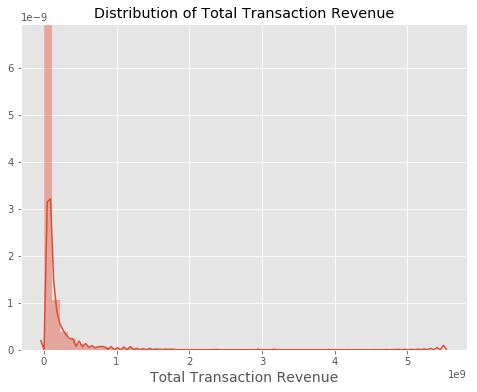

In [170]:

plt.figure(figsize = (8,6))
sns.distplot(rg)
plt.xlabel("Total Transaction Revenue", fontsize = 14)
plt.title("Distribution of Total Transaction Revenue")
plt.show()

It is highly skewed to left side.

Applying log on target variable and plotting the distribution:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



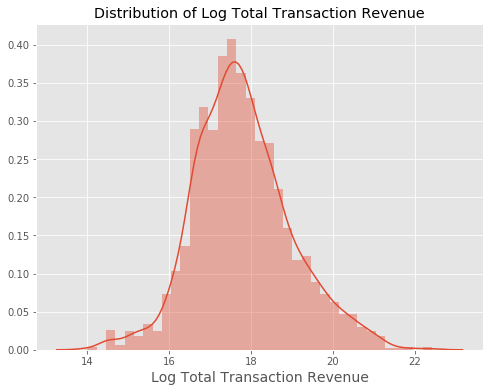

In [171]:
plt.figure(figsize = (8,6))
sns.distplot(rg.apply(np.log1p))
plt.xlabel("Log Total Transaction Revenue", fontsize = 14)
plt.title("Distribution of Log Total Transaction Revenue")
plt.show()

Examining the skew and kurtosis if our log transformed target variable:

In [172]:
from scipy.stats import kurtosis, skew
print(f"Skewness of transction value: {skew(rg.apply(np.log1p))}")
print(f"Kurtosis of transction value: {kurtosis(rg.apply(np.log1p))}")


Skewness of transction value: 0.34920220244527483
Kurtosis of transction value: 0.5517311373938134


Skewness and Kurtosis values indicate log of target variable is almost approximately normally distributed.

**Customers come to Gstore through various channels. Exploring which channles brings more customers:**

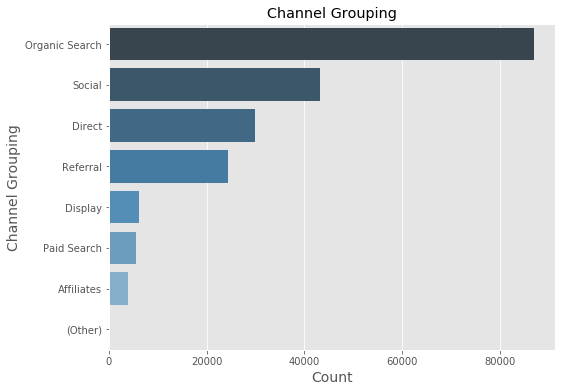

In [173]:
plt.figure(figsize = (8,6))
sns.countplot(y = train['channelGrouping'], order = train['channelGrouping'].value_counts().index, palette='Blues_d')
plt.xlabel("Count", fontsize = 14)
plt.ylabel("Channel Grouping",fontsize = 14)
plt.title("Channel Grouping")
plt.show()

Seems **Organic search** and **Social channels** bring most of the customers through Gstore.

**Exploring how revenue generating customers come to Gstore via various channels:**

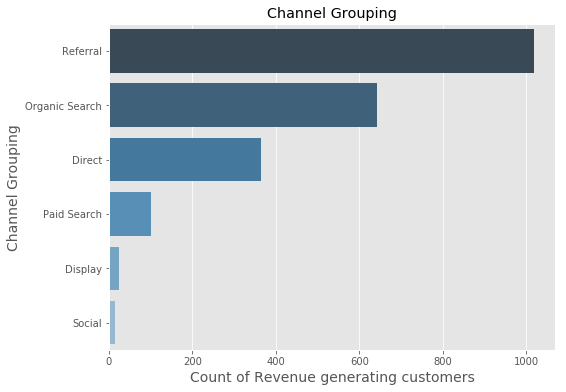

In [174]:
rg = train[train['totals_transactionRevenue'] > 0]

plt.figure(figsize = (8,6))
sns.countplot(y = rg['channelGrouping'], order = rg['channelGrouping'].value_counts().index, palette='Blues_d')
plt.xlabel("Count of Revenue generating customers", fontsize = 14)
plt.ylabel("Channel Grouping",fontsize = 14)
plt.title("Channel Grouping")
plt.show()

**Though Organic search brings more customers, it is through Refferals where revenue generating customers are coming from:**

Grouping revenue generating customers based on channels and see which channels brought more revenue:

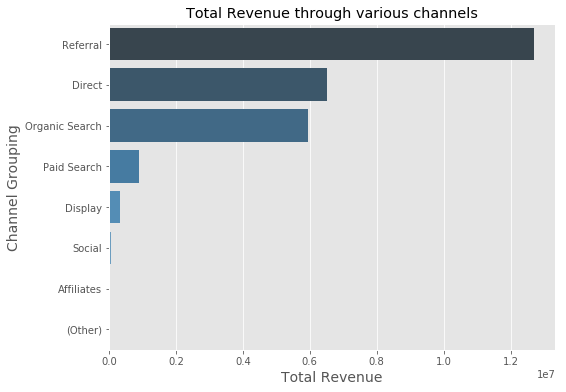

In [175]:
channel_revenue_group = train.groupby('channelGrouping')['totals_transactionRevenue'].sum().apply(lambda x: x/10000)

plt.figure(figsize = (8,6))
sns.barplot(y = channel_revenue_group.index, x = channel_revenue_group.values,palette='Blues_d', order = channel_revenue_group.sort_values(ascending = False).index)
plt.xlabel("Total Revenue", fontsize = 14)
plt.ylabel("Channel Grouping",fontsize = 14)
plt.title("Total Revenue through various channels")
plt.show()

**More the customers, more the revenue. Referral has the most revenue of all channels**

Maximum revenue generated by various channels:

In [176]:
train.groupby('channelGrouping')['totals_transactionRevenue'].max().apply(lambda x: x/10000).sort_values(ascending = False)

channelGrouping
Direct            549800.0
Referral          317122.0
Organic Search    167972.0
Display           119674.0
Paid Search        57955.0
Social             12198.0
Affiliates             0.0
(Other)                0.0
Name: totals_transactionRevenue, dtype: float64

Exploring what **DEVICE BROWSER** are Gstore customers using and which brings more revenue:

Now exploring what browsers does customers use for coming to Gstore:

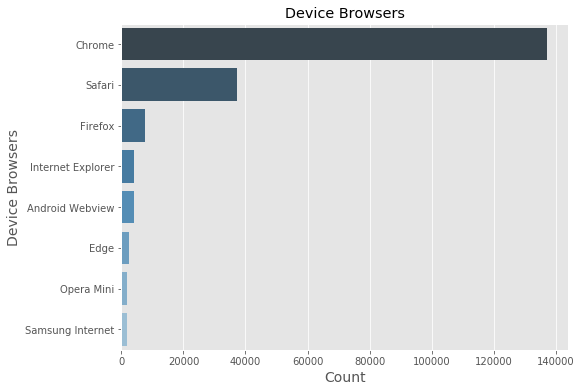

In [177]:
plt.figure(figsize = (8,6))
sns.countplot(y = train['device_browser'], order = train['device_browser'].value_counts().head(8).index, palette='Blues_d')
plt.xlabel("Count", fontsize = 14)
plt.ylabel("Device Browsers",fontsize = 14)
plt.title("Device Browsers")
plt.show()

**Chrome and Safari are the top browsers that customers use to come to Gstore.**

Which browsers are our revenue generating customers using?

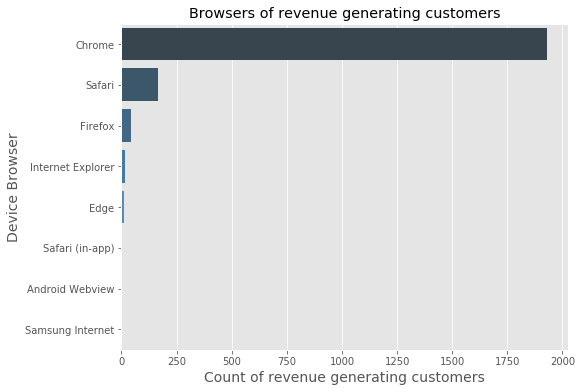

In [178]:
plt.figure(figsize = (8,6))
sns.countplot(y = rg['device_browser'], order = rg['device_browser'].value_counts().index, palette='Blues_d')
plt.xlabel("Count of revenue generating customers", fontsize = 14)
plt.ylabel("Device Browser",fontsize = 14)
plt.title("Browsers of revenue generating customers")
plt.show()

Through which browser does most of the revenue come from?

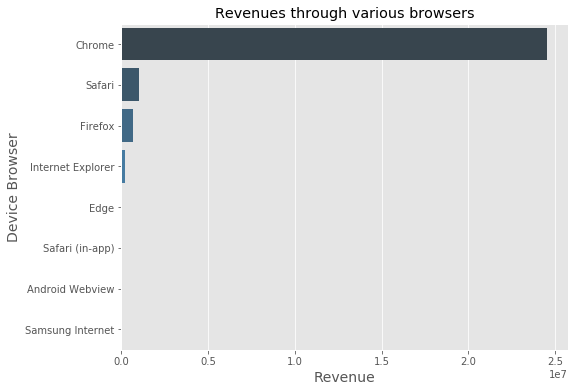

In [179]:
browser_revenue_group = rg.groupby('device_browser')['totals_transactionRevenue'].sum().apply(lambda x: x/10000)

plt.figure(figsize = (8,6))
sns.barplot(y = browser_revenue_group.index, x = browser_revenue_group.values,palette='Blues_d', order = browser_revenue_group.sort_values(ascending = False).index)
plt.xlabel("Revenue", fontsize = 14)
plt.ylabel("Device Browser",fontsize = 14)
plt.title("Revenues through various browsers")
plt.show()

**It's evident that Gstore users mostly use chrome to shop.**

What Browsers and devices do revenue generating customers use to come to Gstore?

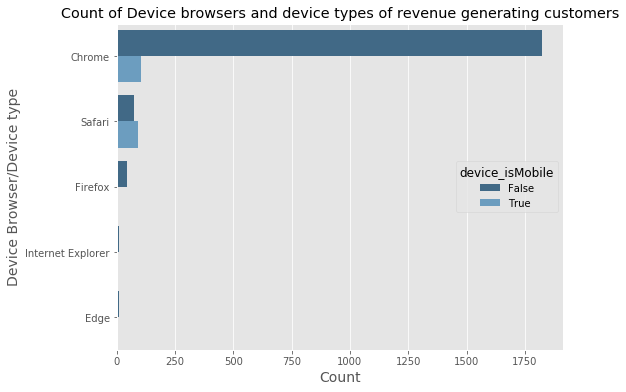

In [180]:
plt.figure(figsize = (8,6))
sns.countplot(y = rg['device_browser'], order = rg['device_browser'].value_counts().head(5).index, hue = rg['device_isMobile'], palette='Blues_d')
plt.xlabel("Count", fontsize = 14)
plt.ylabel("Device Browser/Device type",fontsize = 14)
plt.title("Count of Device browsers and device types of revenue generating customers")
plt.show()

It is evident that **Desktop users, using Chrome browser** spent more money than others.

What Devices do customers use to come to Gstore?

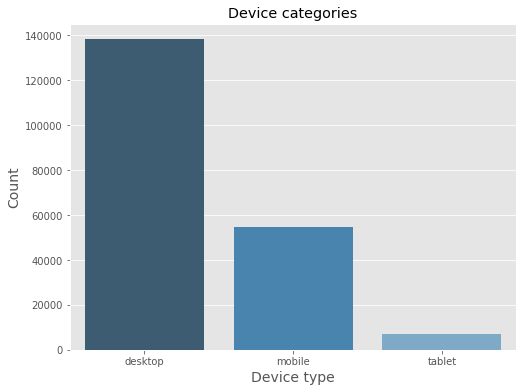

In [181]:

plt.figure(figsize = (8,6))
sns.countplot(x = train['device_deviceCategory'], order = train.device_deviceCategory.value_counts().index, palette='Blues_d')
plt.xlabel("Device type", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Device categories")
plt.show()

**Most of the Gstore customers use their Desktop for shopping. **

What devices does revenue generating customers use to come to Gstore?

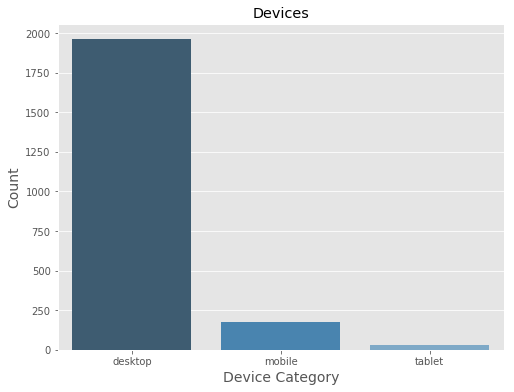

In [182]:
plt.figure(figsize = (8,6))
sns.countplot(x = rg['device_deviceCategory'], order = rg['device_deviceCategory'].value_counts().index, palette='Blues_d')
plt.xlabel("Device Category", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Devices")
plt.show()

**Most Revenue generating customers use Desktop.**

What Operating systems does Gstore customers use?

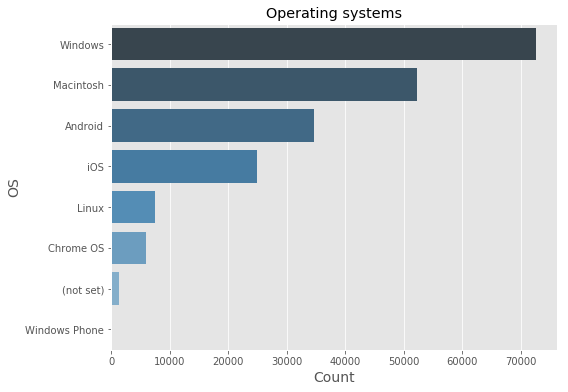

In [183]:
plt.figure(figsize = (8,6))
sns.countplot(y = train['device_operatingSystem'], order = train.device_operatingSystem.value_counts().head(8).index, palette='Blues_d')
plt.xlabel("Count", fontsize = 14)
plt.ylabel("OS",fontsize = 14)
plt.title("Operating systems")
plt.show()

**Windows and Mac are dominant OS which Gstore customers use.**

What OS are revenue generating customers usin?

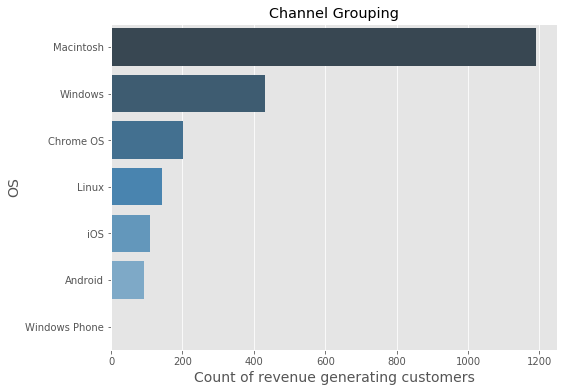

In [184]:
plt.figure(figsize = (8,6))
sns.countplot(y = rg['device_operatingSystem'], order = rg['device_operatingSystem'].value_counts().head(8).index, palette='Blues_d')
plt.xlabel("Count of revenue generating customers", fontsize = 14)
plt.ylabel("OS",fontsize = 14)
plt.title("Channel Grouping")
plt.show()

**There's a variation between above 2 plots. Above plot clearly shows users with MAC OS are buying from Gstore more rather than Windows which has more overall users.**

What is the total revenue based on different operating systems does buyers used?

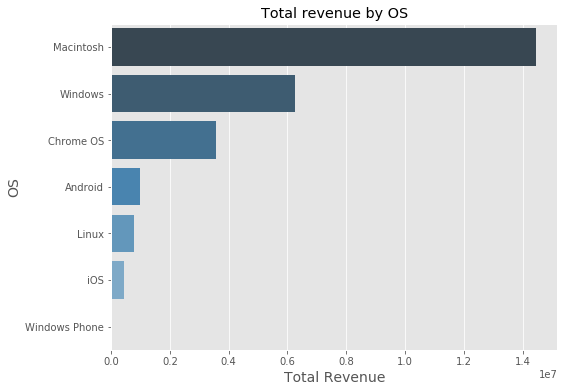

In [185]:
os_revenue_group = train.groupby('device_operatingSystem')['totals_transactionRevenue'].sum().apply(lambda x: x/10000)

plt.figure(figsize = (8,6))
sns.barplot(y = os_revenue_group.index, x = os_revenue_group.values,palette='Blues_d',order = os_revenue_group.sort_values(ascending = False).head(7).index)
plt.xlabel("Total Revenue", fontsize = 14)
plt.ylabel("OS",fontsize = 14)
plt.title("Total revenue by OS")
plt.show()

**Users with Mac spend more total money on Gstore.**

From which devices are buyers coming to Gstore?

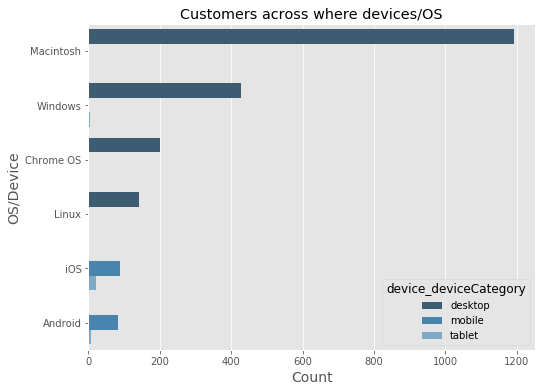

In [186]:
plt.figure(figsize = (8,6))
sns.countplot(y = rg['device_operatingSystem'], order = rg['device_operatingSystem'].value_counts().head(6).index, hue = rg['device_deviceCategory'], palette='Blues_d')
plt.xlabel("Count", fontsize = 14)
plt.ylabel("OS/Device",fontsize = 14)
plt.title("Customers across where devices/OS")
plt.show()

**It is interesting here to note that iOS and Android users from mobile are visting Gstore.**

**Now from which different regions customers are from?**

In [187]:
geo_cols = [col for col in train.columns if 'geoNetwork' in col]

Where are people who visit Gstore are located on the globe?

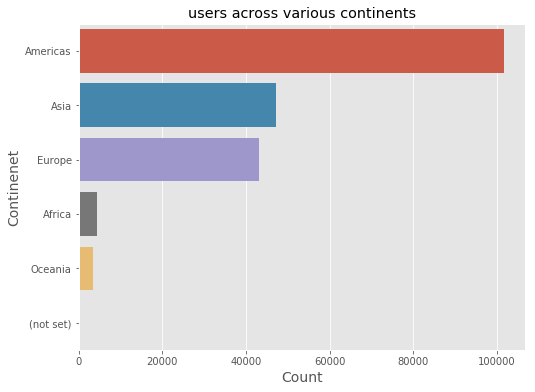

In [188]:
plt.figure(figsize = (8,6))
sns.countplot(y = train['geoNetwork_continent'], order = train['geoNetwork_continent'].value_counts().index)
plt.xlabel("Count", fontsize = 14)
plt.ylabel("Continenet",fontsize = 14)
plt.title("users across various continents")
plt.show()

**Most people coming to Gstore are from Americas and Asia.**

What countries are Gstore customers from?

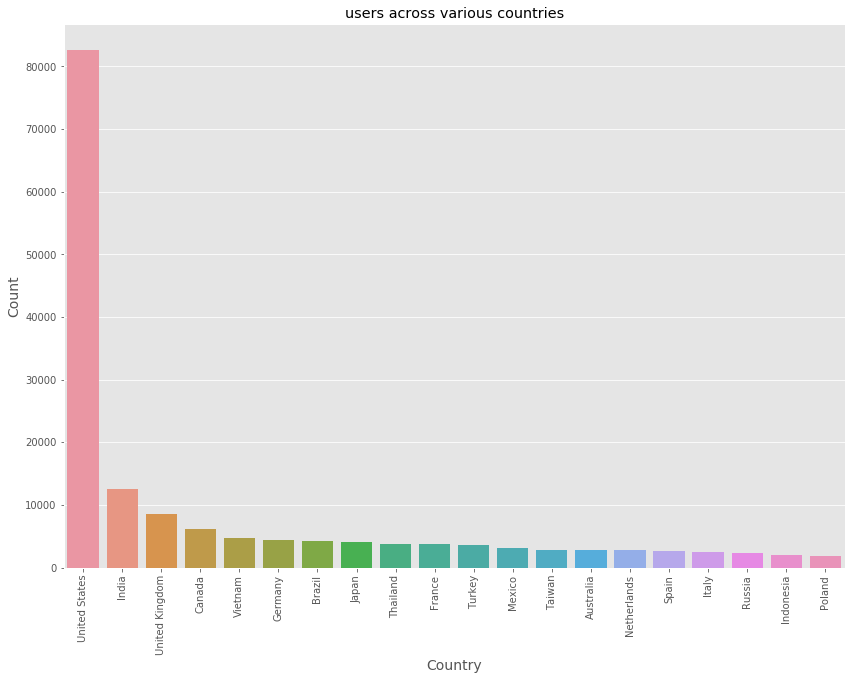

In [189]:
plt.figure(figsize = (14,10))
sns.countplot(x = train['geoNetwork_country'], order = train['geoNetwork_country'].value_counts().head(20).index)
plt.xticks(rotation=90)
plt.xlabel("Country", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("users across various countries")
plt.show()

Gstore sees its users mainly from **US,India,UK and Canada**.

Where are Gstore buyers mostly from?

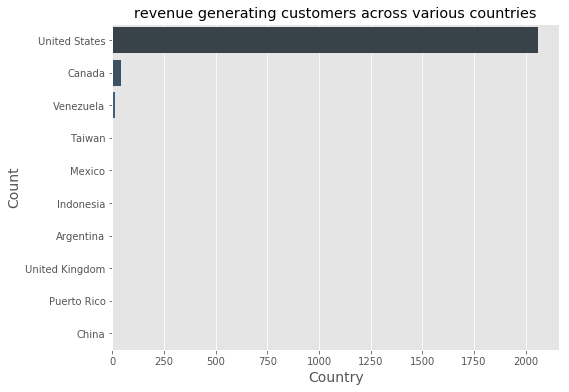

In [190]:
plt.figure(figsize = (8,6))
sns.countplot(y = rg['geoNetwork_country'], order = rg['geoNetwork_country'].value_counts().head(10).index, palette='Blues_d')
plt.xlabel("Country", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("revenue generating customers across various countries")
plt.show()

It's **US and Canada** where most of the revenue generating customers are from.

Since most of Gstore customers are from US, it's only logical to see from which cities these customers are from.

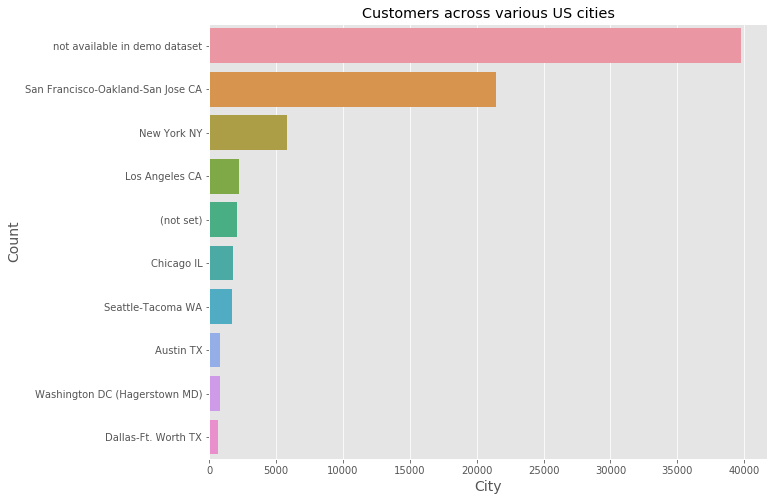

In [191]:
us_traffic = train[train['geoNetwork_country'] == 'United States']

plt.figure(figsize = (10,8))
sns.countplot(y = us_traffic['geoNetwork_metro'], order = us_traffic['geoNetwork_metro'].value_counts().head(10).index)
plt.xlabel("City", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Customers across various US cities")
plt.show()

Most of the users of Gstore are from **San Jose, New York city and Los Angeles.**

Now what does Gstore customers look on a map?

In [192]:
tmp = train['geoNetwork_country'].value_counts()
country_visits = pd.DataFrame(data={'geoNetwork_country': tmp.values}, index=tmp.index).reset_index()
country_visits.columns = ['Country', 'Visits']

In [193]:
colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

def plot_country_map(data, location, z, legend, title, colormap='Rainbow'):
    data = dict(type = 'choropleth', 
                colorscale = colorscale,
                autocolorscale = False,
                reversescale = False,
               locations = data[location],
               locationmode = 'country names',
               z = data[z], 
               text = data[z],
               colorbar = {'title':legend})
    layout = dict(title = title, 
                 geo = dict(showframe = False, 
                         projection = {'type': 'natural earth'}))
    choromap = go.Figure(data = [data], layout=layout)
    iplot(choromap)

In [194]:
plot_country_map(country_visits, 'Country', 'Visits', 'Visits', 'Visits per country')
plt.show()

Red indicates more users and green indiactes less number or no users.

How revenue generating customers would look on a map?

In [195]:
revenue_by_country = rg.groupby('totals_transactionRevenue')['geoNetwork_country'].sum().reset_index()

plot_country_map(revenue_by_country, 'geoNetwork_country', 'totals_transactionRevenue', 'Transaction Revenue', 'Revenue per country')
plt.show()

Red indicates more revenue as compared to whie.

Analysing the Time column might throw more light on consumer behaviour.

In [196]:
train['date'] = pd.to_datetime(train['date'], format = '%Y%m%d')
test['date'] = pd.to_datetime(test['date'], format = '%Y%m%d')

In [197]:
def plot_scatter_data(data, xtitle, ytitle, title, color='blue'):
    trace = go.Scatter(
        x = data.index,
        y = data.values,
        name=ytitle,
        marker=dict(
            color=color,
        ),
        mode='lines+markers'
    )
    data = [trace]
    layout = dict(title = title,
              xaxis = dict(title = xtitle), yaxis = dict(title = ytitle),
             )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='lines')

**Total visits to Gstore over the time:**

In [198]:
count_all = train.groupby('date')['totals_transactionRevenue'].agg(['size'])
count_all.columns = ["Total"]
count_all = count_all.sort_index()
plot_scatter_data(count_all['Total'],'Date', 'Total','Total count of visits (including zero transactions)','green')

There's certainly a dip in transaction revenue during few months and a raise during others.

In [199]:
count_nonzero = train.groupby('date')['totals_transactionRevenue'].agg(['count'])
count_nonzero.columns = ["Total"]
count_nonzero = count_nonzero.sort_index()
plot_scatter_data(count_nonzero['Total'],'Date', 'Total','Total non-zero transaction visits','darkblue')

The above interactive plot explore the buyers trend over time.

In [200]:
total_nonzero = train.groupby('date')['totals_transactionRevenue'].agg(['sum'])
total_nonzero.columns = ["Total"]
total_nonzero = total_nonzero.sort_index()
plot_scatter_data(total_nonzero['Total'],'Date', 'Total','Total non-zero transaction amounts','red')

The above plot shows the total transaction revenue at any particular point of the time.

Now examining how the trends vary over months, days etc.

In [201]:
train_df_date = train.set_index('date')
train_df_date['year'] = train_df_date.index.year
train_df_date['month'] = train_df_date.index.month
train_df_date['weekday'] = train_df_date.index.weekday_name
#train_df_date.head()


In [202]:
train_df_date_rg = train_df_date[train_df_date['totals_transactionRevenue'] > 0]

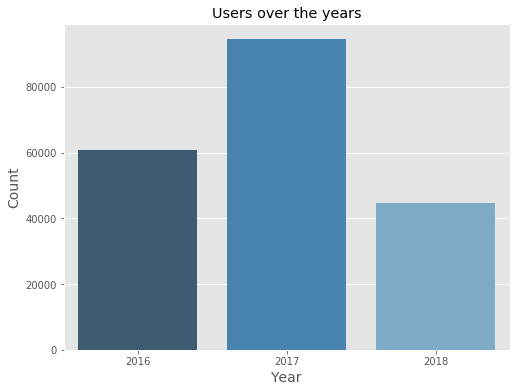

In [203]:
plt.figure(figsize = (8,6))
sns.countplot(train_df_date['year'], palette = 'Blues_d')
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Users over the years")
plt.show()

Year 2017 saw more number of visits to the Gstore.

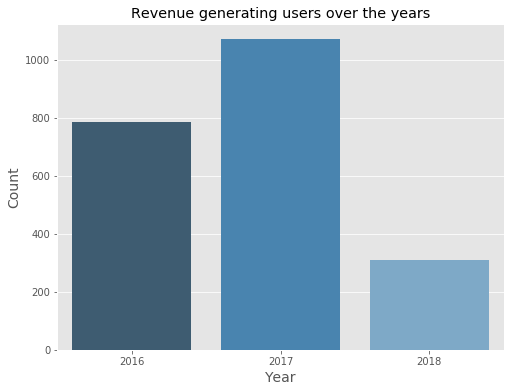

In [204]:
plt.figure(figsize = (8,6))
sns.countplot(train_df_date_rg['year'], palette = 'Blues_d')
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Revenue generating users over the years")
plt.show()

Year 2017, had most revenue than 2017 and 2018.

Which month bought more users?

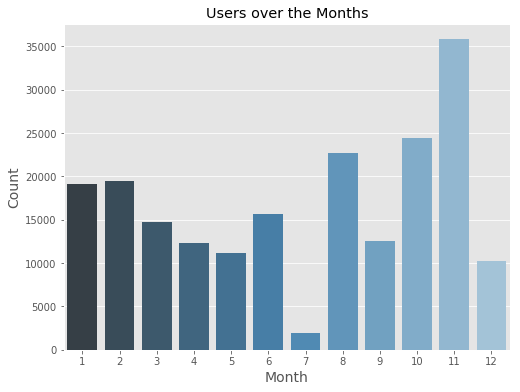

In [205]:
plt.figure(figsize = (8,6))
sns.countplot(train_df_date['month'], palette = 'Blues_d')
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Users over the Months")
plt.show()

November, August and February had more visitors to Gstore.

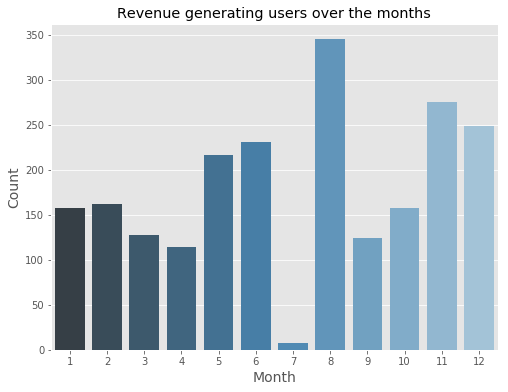

In [206]:
plt.figure(figsize = (8,6))
sns.countplot(train_df_date_rg['month'], palette = 'Blues_d')
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Revenue generating users over the months")
plt.show()

**August bought more revenue to Gstore. Also, November and December also brought more revenue to Gstore. This may be because of the holiday season like Thanksgiving and Christmas, as most of the buyers are from US.**

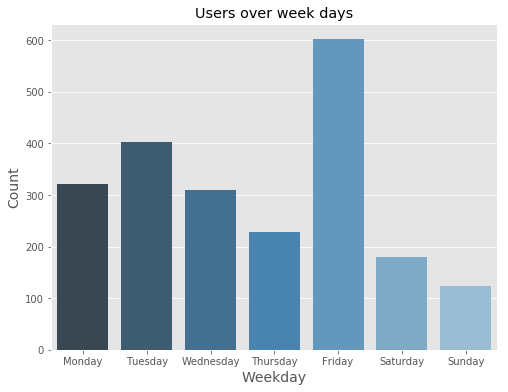

In [207]:
plt.figure(figsize = (8,6))
sns.countplot(train_df_date_rg['weekday'], palette = 'Blues_d', order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel("Weekday", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Users over week days")
plt.show()

Friday had more number of users in the Gstore.

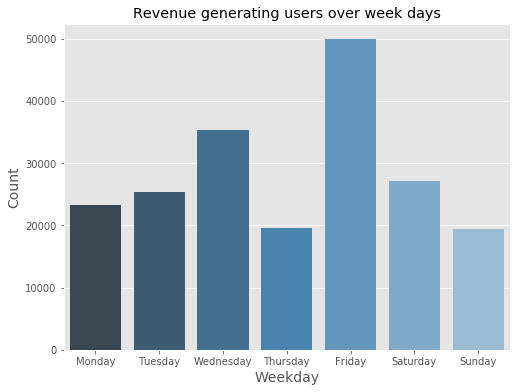

In [208]:
plt.figure(figsize = (8,6))
sns.countplot(train_df_date['weekday'], palette = 'Blues_d', order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel("Weekday", fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.title("Revenue generating users over week days")
plt.show()

Gstore users certainly spends more more money on Fridays and generally on Weekdays.

**Now let's further explore the adcontent, the ads/adwords which brought users to Gstore:**

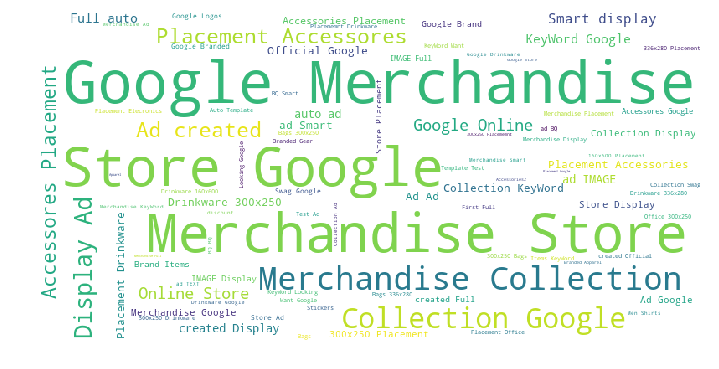

In [209]:
from wordcloud import WordCloud

ad_content = train['trafficSource_adContent'].fillna('')
wordcloud_ad = WordCloud(width=800, height=400, background_color="white").generate(' '.join(ad_content))
plt.figure( figsize=(12,9))
plt.imshow(wordcloud_ad)
plt.axis("off")
plt.show()

**Now through which sources did most users come from?**

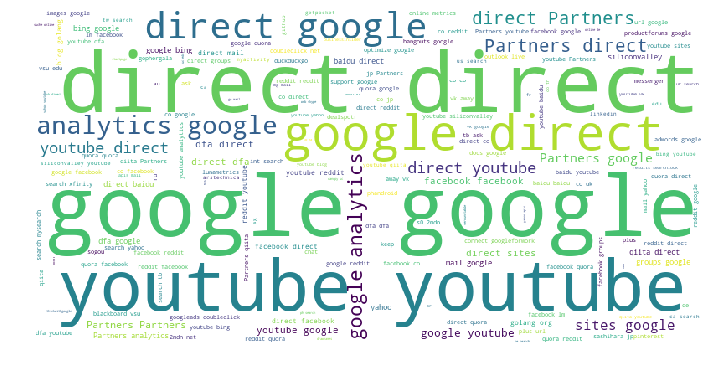

In [210]:
source = train['trafficSource_source'].fillna('')
wordcloud_source = WordCloud(width=800, height=400, background_color="white").generate(' '.join(source))
plt.figure( figsize=(12,9))
plt.imshow(wordcloud_source)
plt.axis("off")
plt.show()

## Conclusion

* So, based on the plots above it can be inferred that, most revenue generating customers come from US who use Chrome browser on Mac. They are most likely to spend their money on Fridays and during holiday seasons. 
* Since, we saw referrals bought more revenue than other sources, it is wise to give referral coupons or similar referral bonuses to bring more revenue to Gstore. Similar referral strategies can be used in other potential revenue generating countries like Canada, UK and India.
* From the word clouds above, it is seen that, more customers come to Gstore through google search/youtube. There is a good chance to attract customers by giving more ads in these platforms, preferably during holiday seasons of respective countries.